# **Anàlisi de l'Indian Liver Dataset** 

En aquesta Notebook s'hi inclou tot el codi usat des de l'EDA, preprocessament, entrenament, avaluació dels models i generació de la predicció en el format de Kaggle. A més, s'hi inclouen anotacions explicant diversos aspectes que s'han anat implementant, que estaran concretats al document adjunt de l'entrega.

NOTA: En general, conté força textos i explicacions, però s'han fet com a recordatoris i per tenir dades que s'explicaran a l'informe.

### **Imports de tota la pràctica**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessament
from sklearn.preprocessing import RobustScaler

# Selecció i avaluació models
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier

# Gestió desequilibri
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Sortida neta a cross-validation
warnings.simplefilter(action='ignore', category=FutureWarning)

# Replicabilitat
RANDOM_STATE = 50

### **Càrrega de dades**

In [2]:
X_features = pd.read_csv('train_features_ILDS.csv', header=None)
y_labels_raw = pd.read_csv('train_labels_ILDS.csv', header=None)
X_test_kaggle = pd.read_csv('test_data_ILDS.csv', header=None)

column_names = ['Age', 'Female', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/R']
X_features.columns = column_names
X_test_kaggle.columns = column_names

y_labels = y_labels_raw[0]

print(X_features.shape)
print(y_labels.shape)
print(X_test_kaggle.shape)

print("\nPrimeres files entrenament:")
print(X_features.head())
print("\nPrimeres files etiquetes entrenament:")
print(y_labels.head())
print("\nPrimeres files test:")
print(X_test_kaggle.head())

(463, 10)
(463,)
(116, 10)

Primeres files entrenament:
   Age  Female   TB   DB  Alkphos  Sgpt  Sgot   TP  ALB   A/R
0   40       0  3.9  1.7      350   950  1500  6.7  3.8  1.30
1   48       0  4.5  2.3      282    13    74  7.0  2.4  0.52
2   39       0  1.9  0.9      180    42    62  7.4  4.3  1.38
3   23       0  1.0  0.3      212    41    80  6.2  3.1  1.00
4   42       1  0.7  0.2      152    35    81  6.2  3.2  1.06

Primeres files etiquetes entrenament:
0    0
1    0
2    0
3    0
4    0
Name: 0, dtype: int64

Primeres files test:
   Age  Female   TB   DB  Alkphos  Sgpt  Sgot   TP  ALB   A/R
0   11       0  0.7  0.1      592    26    29  7.1  4.2  1.40
1   62       0  1.8  0.9      224    69   155  8.6  4.0  0.80
2   60       0  0.7  0.2      174    32    14  7.8  4.2  1.10
3   60       0  5.7  2.8      214   412   850  7.3  3.2  0.78
4   48       1  0.9  0.2      175    24    54  5.5  2.7  0.90


### **Anàlisi exploratòria de les dades**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      463 non-null    int64  
 1   Female   463 non-null    int64  
 2   TB       463 non-null    float64
 3   DB       463 non-null    float64
 4   Alkphos  463 non-null    int64  
 5   Sgpt     463 non-null    int64  
 6   Sgot     463 non-null    int64  
 7   TP       463 non-null    float64
 8   ALB      463 non-null    float64
 9   A/R      463 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 36.3 KB


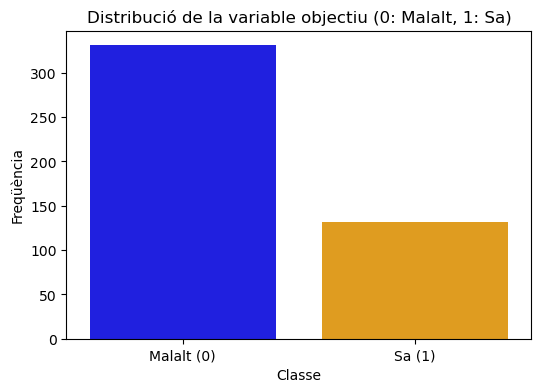

In [3]:
# Analitzarem la distribució de les dades, començant per la variable objectiu.

X_features.info()

plt.figure(figsize=(6, 4))

sns.countplot(
    x=y_labels.map({0: 'Malalt (0)', 1: 'Sa (1)'}),
    palette={'Malalt (0)': 'blue', 'Sa (1)': 'orange'}
)

plt.title('Distribució de la variable objectiu (0: Malalt, 1: Sa)')
plt.xlabel('Classe')
plt.ylabel('Freqüència')
plt.show()

El gràfic de la distribució de la variable resposta mostra un clar desequilibri de classes: la classe '0' (pacients malalts) és considerablement més nombrosa que la classe '1' (pacients sans). Aquest desequilibri és un factor important a considerar, ja que pot esbiaixar els models cap a la classe majoritària, predint sempre com a malalt: per això es farà servir la mètrica F1-mean principalment, amb altres auxiliars que explicarem al document i en aquest notebook més endavant.

S'aplicaràn tècniques com SMOTE (i més) a la fase d'entrenament dels models, de manera que aquest imbalanç no afecti al model. 

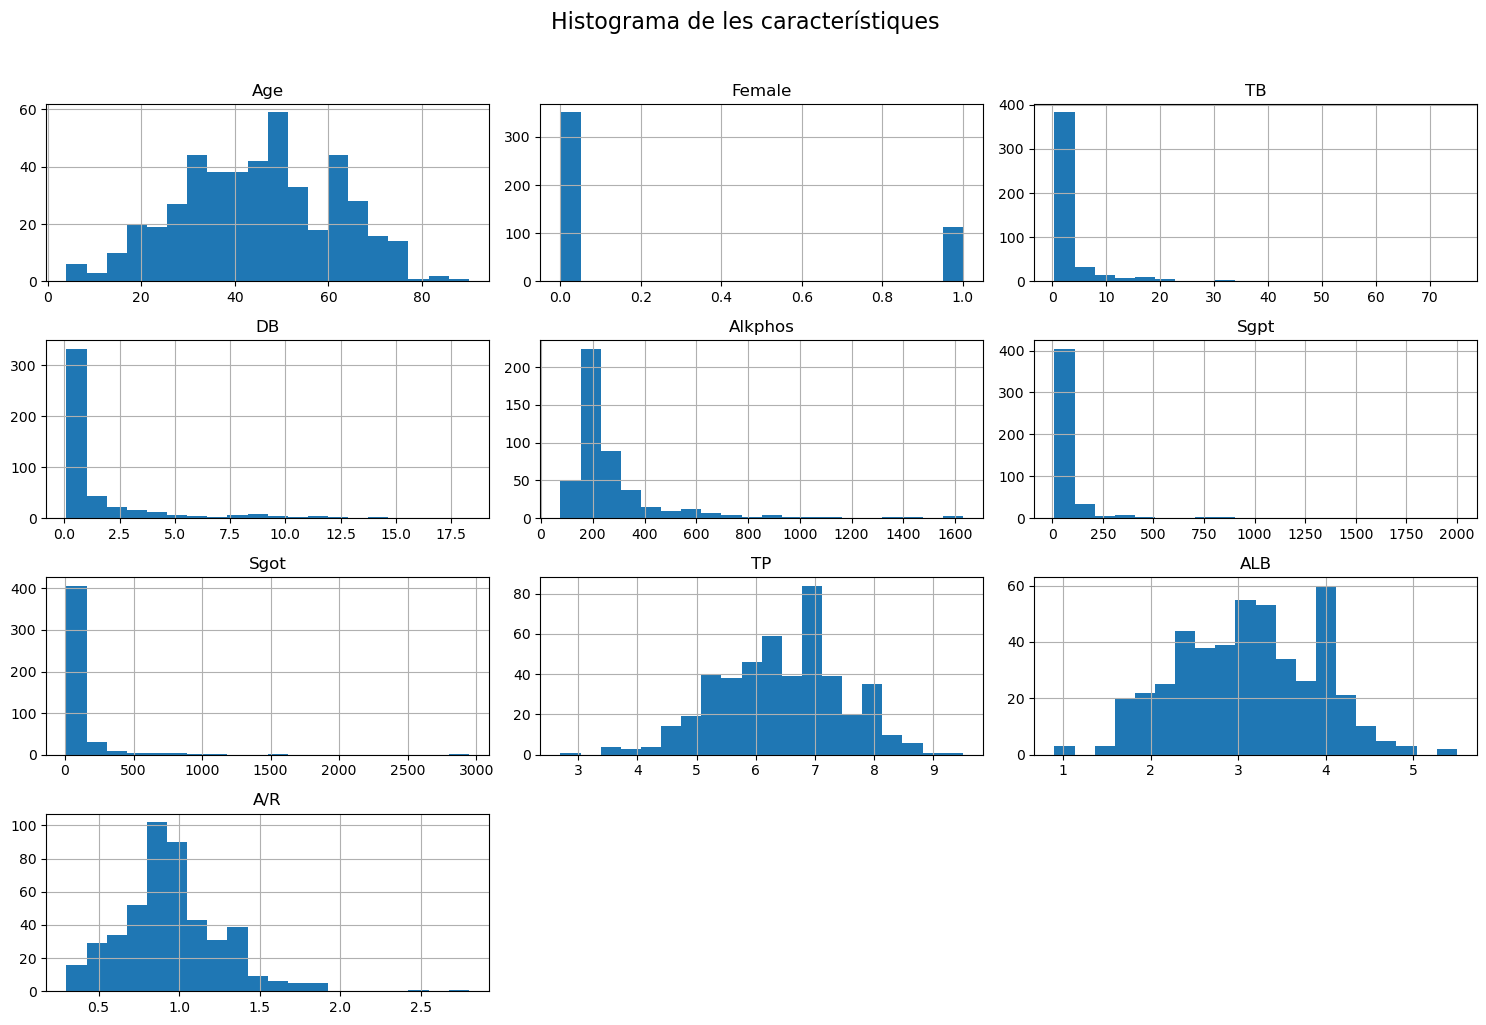

In [4]:
# Histograma de les variables explicatives (totes són numèriques)

numeric_cols = X_features.columns.tolist()
X_features[numeric_cols].hist(bins=20, figsize=(15, 10), layout=(-1, 3))
plt.suptitle("Histograma de les característiques", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

L'anàlisi de la distribució de les característiques proporciona informació molt rellevant pel nostrel model: característiques com 'Age', 'TP', 'ALB' i 'A/R' mostren distribucions relativament normals, sent 'ALB' i 'Age' les que més s'aproximen a gaussianes. Female, en ser una variable binària, mai serà gaussiana, només ens mostra una proporció.

Per altra banda, 'TB', 'DB', 'Alkphos', 'Sgpt' i 'Sgot', presenten un biaix cap a la dreta (right-skewed), és a dir, la majoria dels valors es concentren a la part baixa de l'escala. Això és un indicador de la presència d'outliers, fet que té sentit, ja que en aquestes dades clíniques certs pacients presenten valors elevats d'aquests marcadors. Al preprocessat es tracten aquests dos problemes amb RobustScaler i log1p, explicant el motiu de la seva efectivitat.

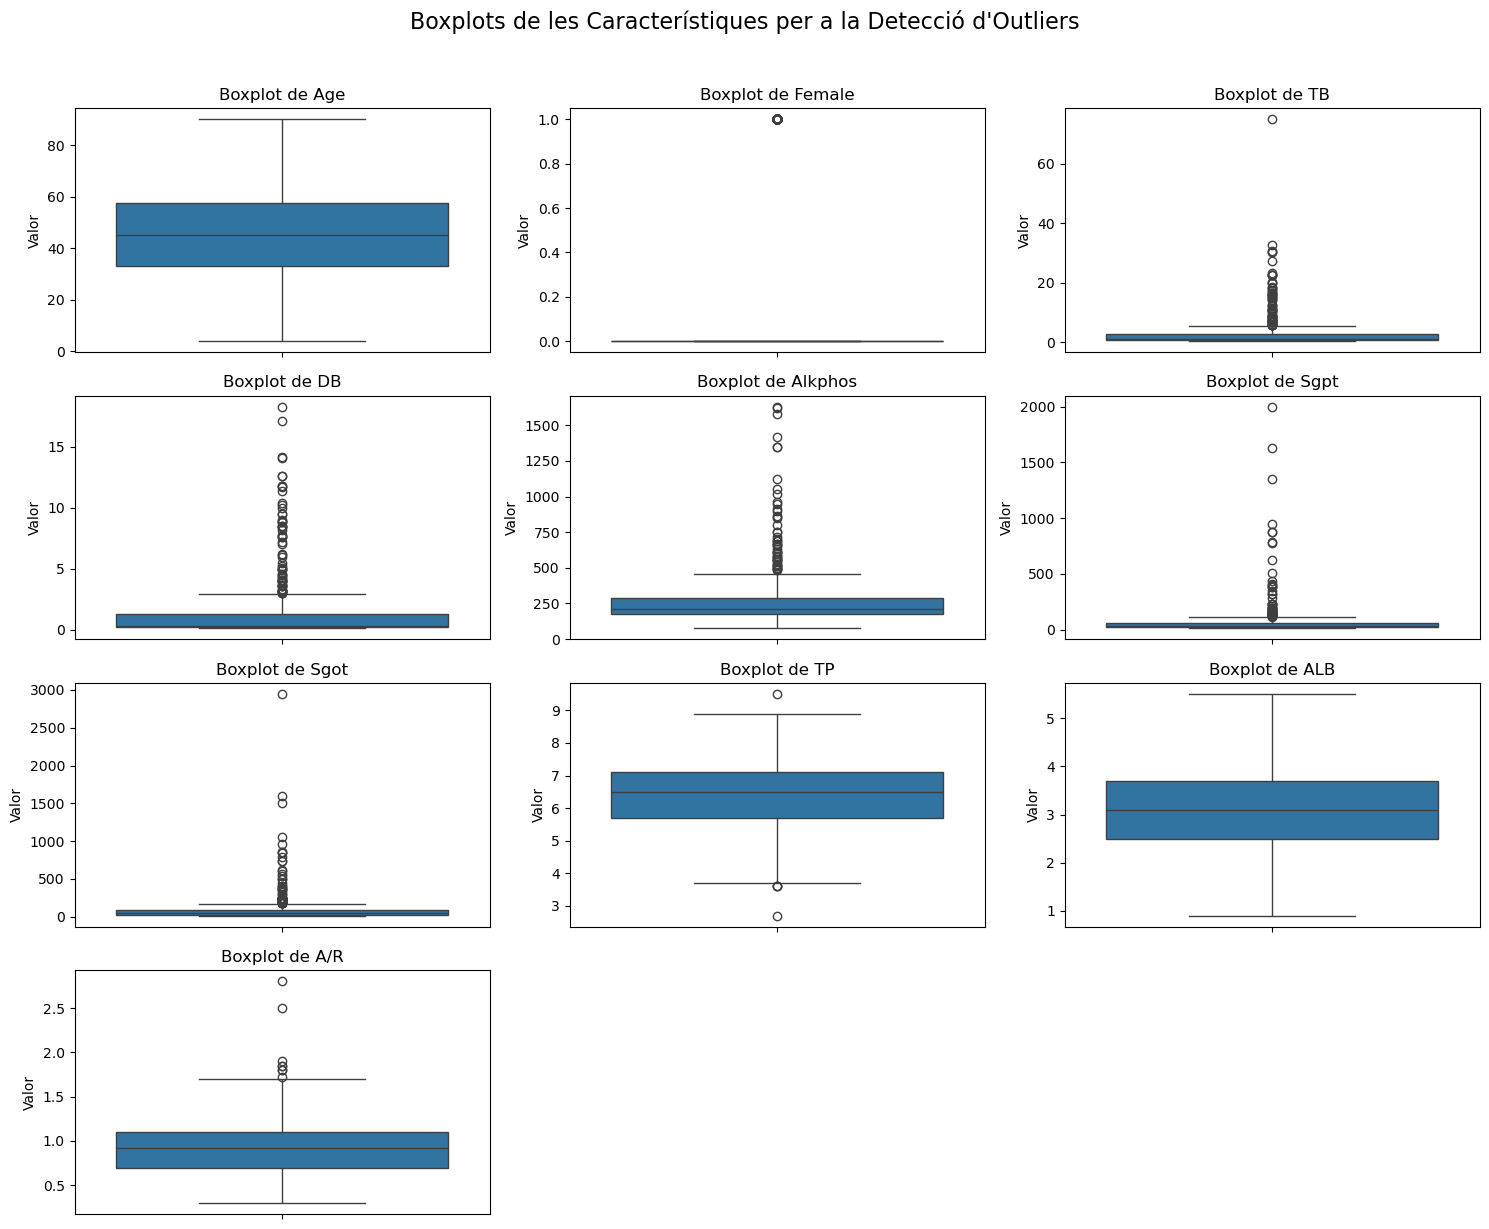

In [5]:
# Boxplots per a cada característica per visualitzar outliers

plt.figure(figsize=(15, 12))
plt.suptitle("Boxplots de les Característiques per a la Detecció d'Outliers", y=1.02, fontsize=16)

numeric_cols = X_features.columns.tolist()

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(y=X_features[col])
    plt.title(f'Boxplot de {col}')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

Els boxplots confirmen visualment les observacions dels histogrames: les variables TB, DB, Alkphos, Sgpt i Sgot tenen una gran quantitat d'outliers. Aquesta forta presència de valors extrems fa que l'ús de RobustScaler sigui una elecció molt més adequada que altres escaladors com StandardScaler, ja que ens ajudarà a construir models menys sensibles a aquests valors i, per tant, més robustos.

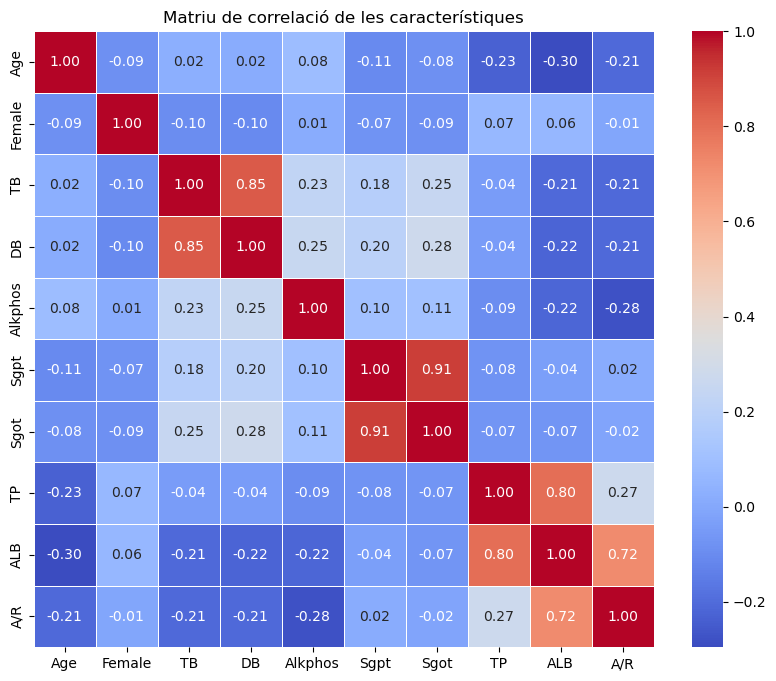

In [6]:
plt.figure(figsize=(10, 8))
corr_matrix = X_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriu de correlació de les característiques')
plt.show()

En general, s'observa que la majoria de les correlacions són baixes o moderades, la qual cosa és positiva ja que indica que no hi ha redundància entre les variables.

Tot i això, tenim algunes correlacions positives fortes, que s'expliquen fent una lleugera investigació biomèdica:
- Entre 'TB' (Bilirubina Total) i 'DB' (Bilirubina Directa) amb un valor de 0.85, la qual cosa és esperable donada la seva relació fisiològica.
- Entre 'Sgpt' (Transaminasa Alanina) i 'Sgot' (Transaminasa Aspartat) amb una correlació molt alta de 0.91, indicant que aquests dos enzims hepàtics sovint varien conjuntament.
- Entre 'TP' (Proteïnes Totals) i 'ALB' (Albúmina) amb 0.80, i entre 'ALB' i 'A/R' (Rati Albumina/Globulina) amb 0.72, també relacions conegudes en anàlisis clíniques.

Aquestes altes correlacions no representen un problema per a la majoria dels models que utilitzarem, especialment aquells basats en arbres de decisió com Random Forest o Extra Trees, però hi ha mesures clínicament rellevants que podem fer per reduir la multicol·linealitat entre variables:

### **Feature engineering**

S'han aplicat dues transformacions per millorar el rendiment dels models abordant la multicol·linealitat observada:

- **Bilirrubina Indirecta (IB)**
  - Es crea una nova característica, la bilirrubina indirecta, calculada com la diferència entre la bilirubina total (TB) i la directa (DB):
    ```
    IB = TB - DB
    ```
  - Un cop calculada la IB, s'elimina la columna `DB` per evitar la col·linealitat entre les tres variables (`TB`, `DB` i `IB`), conservant `TB` com a marcador principal i `IB` com a marcador específic.

- **Eliminació de les Proteïnes Totals (TP)**
  - Degut a l'alta correlació (0.80) entre les proteïnes totals (`TP`) i l'albúmina (`ALB`), s'elimina la columna `TP`.
  - Aquesta decisió es pren per mantenir `ALB`, que és un indicador clínic més específic de la funció hepàtica, reduint així la redundància en el conjunt de dades.

Aquestes decisions no només han sigut recolzades pels criteris clínics i multicol·linealitat, sinò també pel conjunt de validació i de test públic.

Files amb IB negativa en X_features: 1
Files amb IB negativa en X_test_kaggle: 2


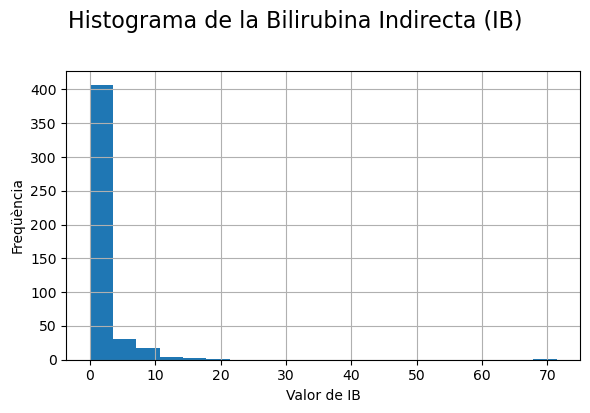

In [7]:
X_features['IB'] = X_features['TB'] - X_features['DB']
X_test_kaggle['IB'] = X_test_kaggle['TB'] - X_test_kaggle['DB']

X_features.drop(columns=['DB', 'TP'], inplace=True)
X_test_kaggle.drop(columns=['DB', 'TP'], inplace=True)

print("Files amb IB negativa en X_features:", (X_features['IB'] < 0).sum())
print("Files amb IB negativa en X_test_kaggle:", (X_test_kaggle['IB'] < 0).sum())

X_features['IB'] = X_features['IB'].clip(lower=0)
X_test_kaggle['IB'] = X_test_kaggle['IB'].clip(lower=0)

plt.figure(figsize=(6, 4))
X_features['IB'].hist(bins=20)
plt.suptitle("Histograma de la Bilirubina Indirecta (IB)", y=1.02, fontsize=16)
plt.xlabel("Valor de IB")
plt.ylabel("Freqüència")
plt.tight_layout()
plt.show()

En calcular la bilirubina indirecta es van detectar valors negatius, un resultat que fisiològicament és impossible. Això es deu a petits errors de mesurament del laboratori, on el valor de la bilirrubina directa (DB) pot superar lleugerament el de la total (TB), especialment en nivells baixos. Per corregir-ho, es va aplicar el mètode .clip(lower=0) de Pandas, que converteix tots els valors negatius d'IB a zero, assegurant la coherència de les dades. Segueix sent esbiaxada a la dreta.

**Experiment 1: Ràtio SGOT/SGPT**

- **Hipòtesi:** Crear el ràtio SGOT/SGPT (ràtio de De Ritis), una mètrica clínica comuna, podria reduir la multicol·linealitat (correlació de 0.91) i millorar el model.

- **Acció:** Es va crear la característica `SGOT/SGPT` i es van eliminar les columnes `Sgot` i `Sgpt`.

- **Resultat:** Contràriament a l'esperat, tant les mètriques en validació creuada com el resultat en el test públic de Kaggle van empitjorar.

- **Conclusió:** Sembla ser que els models extreuen més informació de les variables per separat que del seu ràtio.

### **Preprocessament i avaluació dels models**

Com s'ha vista a l'EDA, les columnes 'TB', 'Alkphos', 'Sgpt', 'Sgot' i 'IB' corresponen a variables amb distribucions sesgades a la dreta, de manera que la transformació logarítmica ajuda a:

1. **Obtenir gaussanitat**: Aquestes variables tenen valors extrems molt grans en comparació amb la majoria de mostres. Aplicar `log1p(x) = log(1 + x)` fa que les cues llargues s'aplanin i la distribució s’assembli més a una forma gaussiana.
2. **Millorar els models que entrenarem**: Alguns models que farem servir com el SVC o regressió logística són sensibles a outliers i aquesta transformació fa que s'incrementi el seu rendiment.

L'aplicarem a totes les dades d'entrenament i també a les de test de Kaggle per poder fer la predicció correctament.

In [8]:
cols_to_log = ['TB', 'Alkphos', 'Sgpt', 'Sgot', 'IB']
X_processed_train = X_features.copy()
X_processed_test_kaggle = X_test_kaggle.copy()

for col in cols_to_log:
    X_processed_train[col] = np.log1p(X_processed_train[col])
    X_processed_test_kaggle[col] = np.log1p(X_processed_test_kaggle[col])

Aquesta transformació ha estat present durant totes les proves i s'ha intentat treure i comparar amb moltes variants, i en tots els casos sempre ha millorat validació i test públic, com és d'esperar teòricament.

Per altra banda, donat que hi ha diversos models sensibles a l'escala (SVC, KNN i LR), s'ha utilitzat `RobustScaler`. La seva aplicació és molt important ja que té en compte la **mediana** i el **rang interquartílic (IQR)**, en lloc de la mitjana i desviació estàndard de StandardScaler. La justificació per aquesta elecció és que a l'EDA es van veure molts outliers, i per tant, aquest canvi en l'scaler de Standard a Robust ha sigut clau per millorar els nostres models tant en validació com en el test públic.

Per evitar data leakage, l'escalador aprèn els paràmetres d'escalat només de les dades d'entrenament i després les aplica a les dades de test.


In [9]:
scaler = RobustScaler()
X_scaled_train_full = scaler.fit_transform(X_processed_train)
X_scaled_test_kaggle = scaler.transform(X_processed_test_kaggle)

X_scaled_train_full_df = pd.DataFrame(X_scaled_train_full, columns=X_processed_train.columns, index=X_processed_train.index)
X_scaled_test_kaggle_df = pd.DataFrame(X_scaled_test_kaggle, columns=X_processed_test_kaggle.columns, index=X_processed_test_kaggle.index)

**Experiment 2**

- **Hipòtesi:** Utilitzar `StandardScaler`, l'escalador més comú, podria oferir un rendiment comparable o superior a `RobustScaler`. Aquest escalador normalitza les dades restant la mitjana i dividint per la desviació estàndard.

- **Acció:** Es va substituir l'escalador `RobustScaler` per `StandardScaler` i es van reentrenar els models.

- **Resultat:** L'ús de `StandardScaler` va provocar una lleugera però consistent disminució en el rendiment de la majoria dels models, tant en validació creuada com en el test públic. La puntuació F1 del millor model va baixar en comparació amb la versió original.

- **Conclusió:** `StandardScaler` és sensible als valors atípics (*outliers*), ja que la mitjana i la desviació estàndard es veuen molt afectades per aquests. `RobustScaler`, en utilitzar la mediana i el rang interquartílic (IQR), és més resistent a aquests valors extrems. Per tant, s'ha mantingut per garantir un preprocés més fiable i un millor rendiment del model final.

### **Tractament del desequilibri**

Com s'ha vist a l'EDA, s'ha de tractar l'imbalanç entre classes. A continuació, expliquem el que s'ha fet en aquest codi per no tenir un model esbiaxat:

1.  **Particions estratificades**
    *   S'ha utilitzat `StratifiedKFold` per mantenir la mateixa proporció de classes en cada partició durant la validació creuada i l'ajust d'hiperparàmetres.

2.  **Sobremostreig amb SMOTE**
    *   A cada pipeline hem inclòs un pas de `SMOTE(random_state=RANDOM_STATE)` per generar exemples sintètics de la classe minoritària (persones sanes, classe 1).

3.  **Mètriques equilibrades**
    *   S'utilitzen mesures adaptades al desequilibri per avaluar el rendiment de cada model:
        *   **F1-score (macro)**
        *   **AUC-ROC** per la classe Sa (classe 1, la minoritària)
        *   **Precisió** i **recall** per a ambdues classes (Malalt i Sa)

4.  **Ajust de llindar de decisió**
    *   Es fa una cerca de llindar entre diferents valors, seleccionat segons la F1-score (macro) calculada sobre les prediccions de cross-validation.

5.  **Ensamblatge amb VotingClassifier**
    *   Aquest model combina diversos classificadors i optimitza els pesos de votació per detectar bé la classe minoritària (persones sanes).

**Experiment 3**

- **Hipòtesi:** Utilitzar `SMOTEENN`, una tècnica híbrida que combina el sobremostreig de SMOTE amb el submostreig de *Edited Nearest Neighbours* (ENN), podria millorar el rendiment. La idea és que després de crear mostres sintètiques, ENN netegi les mostres que puguin ser sorolloses o que estiguin mal classificades, creant una frontera de decisió més clara.

- **Acció:** Es va substituir el *sampler* `SMOTE` per `SMOTEENN` en tots els pipelines i es van reentrenar els models.

- **Resultat:** Aquesta tècnica no va aportar una millora significativa. Els resultats en validació creuada van ser lleugerament inferiors als obtinguts amb `SMOTE`. A més, el rendiment en el test públic de Kaggle no va superar els resultats del nostre millor model actual.

- **Conclusió:** Per a aquest conjunt de dades, la neteja addicional que realitza ENN no sembla beneficiar el rendiment global dels models. És possible que eliminés algunes mostres útils de la frontera de decisió. Per tant, es va descartar `SMOTEENN` a favor de la simplicitat d'`SMOTE`.

**Experiment 4**

- **Hipòtesi:** Utilitzar el paràmetre `class_weight='balanced'` en els classificadors que ho permeten (com `LogisticRegression`, `SVC` i els basats en arbres) podria ser una alternativa eficient a SMOTE. Aquesta tècnica no genera dades noves, sinó que ajusta la funció de pèrdua del model per penalitzar més els errors en la classe minoritària.

- **Acció:** Es van eliminar els passos de `SMOTE` dels pipelines i es va afegir `class_weight='balanced'` als paràmetres dels classificadors corresponents.

- **Resultat:** Tot i ser computacionalment més ràpid, aquesta estratègia va oferir un **rendiment general inferior** a l'obtingut amb SMOTE. Les mètriques en validació creuada van disminuir i el resultat en el test públic de Kaggle no va millorar respecte a la millor implementació.

- **Conclusió:** Per a aquest problema, la generació de mostres sintètiques amb SMOTE per equilibrar la distribució de les classes abans de l'entrenament resulta ser una estratègia més efectiva. Es va descartar l'ús de `class_weight` i es va mantenir SMOTE com a tècnica principal per tractar el desequilibri.

NOTA: També s'han provat altres mètodes com BorderlineSMOTE, però el resultat és el mateix: SMOTE sembla ser el millor per aquestes dades en validació i en la part de test pública pels models usats.

In [10]:
smote_sampler = SMOTE(random_state=RANDOM_STATE)
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Guardem informació dels models (evitem repetir càlculs costosos)
best_estimators_map = {}
best_thresholds_map_cv = {}
all_model_f1_optimized = {} # quan s'ha optimitzat el llindar

Per cada model, s'havia reutilitzat codi en diverses cel·les del Notebook per calcular el llindar. El que s'ha fet per millorar l'eficiència i llegibilitat del codi és crear una funció, com també s'ha fet amb les mètriques del final.

In [11]:
def find_optimal_threshold(model_pipeline, X, y, cv_strategy, threshold_range, model_name, thresholds_map, f1_scores_map):
    y_proba_cv = cross_val_predict(
        model_pipeline, X, y, cv=cv_strategy, method='predict_proba',
    )

    best_f1_score = 0.0
    best_threshold = 0.5

    for threshold in threshold_range:
        y_pred_temp = (y_proba_cv[:, 1] >= threshold).astype(int)
        current_f1 = f1_score(y, y_pred_temp, average='macro')

        if current_f1 > best_f1_score:
            best_f1_score = current_f1
            best_threshold = threshold

    thresholds_map[model_name] = best_threshold
    f1_scores_map[model_name] = best_f1_score

    print(f"Millor llindar {model_name} (en les prediccions de cross-validation): {best_threshold:.4f} amb F1 Macro: {best_f1_score:.4f}")

### **Model 1: Regressió Logística**

In [12]:
# Pipeline amb SMOTE i el model, es farà el mateix procediment per a tots els models
pipeline_lr = ImbPipeline([
    ('smote', smote_sampler), ('classifier', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000))
])

# Trobar hiperparàmetres
grid_search_lr = GridSearchCV(
    pipeline_lr,
    {'classifier__C': [0.005, 0.01, 0.05, 0.1], 'classifier__penalty': ['l1', 'l2']},
    cv=cv_strategy, scoring='f1_macro', refit=True
)

grid_search_lr.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_lr_model_pipeline = grid_search_lr.best_estimator_
best_estimators_map['LogisticRegression'] = best_lr_model_pipeline
print(f"Millors hiperparàmetres LR mitjançant CV: {grid_search_lr.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_lr_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.30, 0.70, 81),
    model_name='LogisticRegression', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres LR mitjançant CV: {'classifier__C': 0.005, 'classifier__penalty': 'l2'}
Millor llindar LogisticRegression (en les prediccions de cross-validation): 0.5100 amb F1 Macro: 0.6628


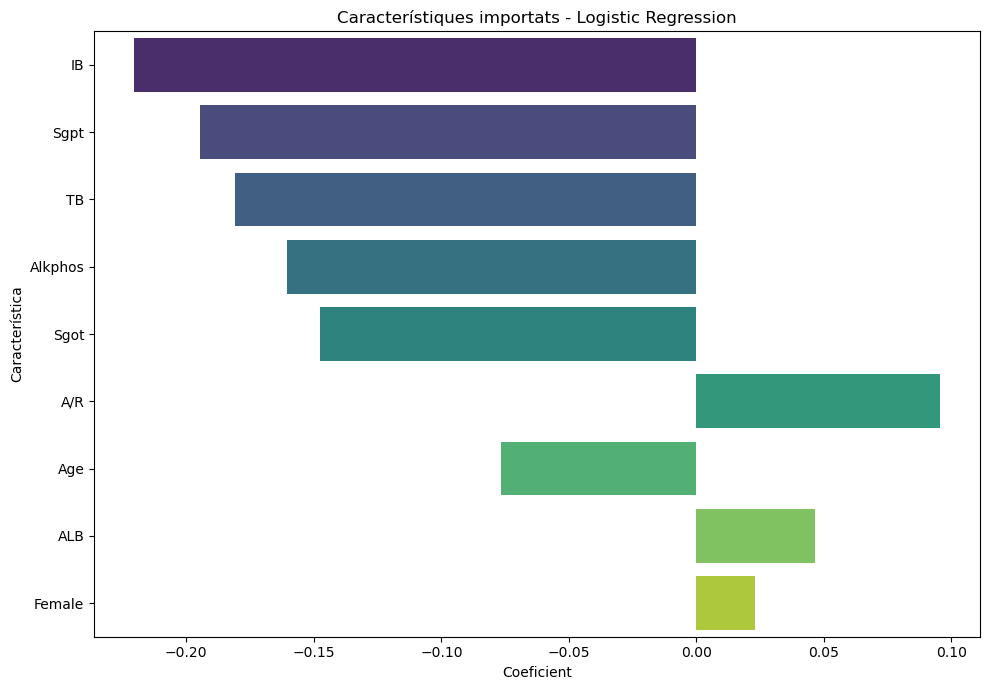

In [13]:
# Característiques que aquest model considera més importants

lr_classifier = best_lr_model_pipeline.named_steps['classifier']
coefficients = lr_classifier.coef_[0]
feature_names = X_scaled_train_full_df.columns

coef_series = pd.Series(coefficients, index=feature_names) # ordenem per valor absolut coeficients
coef_series = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 7))
sns.barplot(x=coef_series.values, y=coef_series.index, palette="viridis")
plt.title('Característiques importats - Logistic Regression')
plt.xlabel('Coeficient')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()


La regressió logística és la baseline: segons aquest model, les característiques de l'esquerra (negatives) suggereixen malaltia hepàtica, mentre que les de la dreta apunten cap a una persona sana. Variables com TB, Sgpt i IB semblen ser indicadors forts de malaltia, mentre que A/R i ALB podria ser un indicador de salut.

### **Model 2: Extra Trees Classifier**

In [14]:
# Pipeline amb SMOTE i el model
pipeline_et = ImbPipeline([('smote', smote_sampler), ('classifier', ExtraTreesClassifier(random_state=RANDOM_STATE))])

# Trobar hiperparàmetres
grid_search_et = GridSearchCV(pipeline_et, {'classifier__n_estimators': [25, 50, 75, 125], 'classifier__max_depth': [10, 20], 'classifier__min_samples_split': [2, 3, 6], 'classifier__min_samples_leaf': [2, 4]}, cv=cv_strategy, scoring='f1_macro', refit=True)
grid_search_et.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_et_model_pipeline = grid_search_et.best_estimator_
best_estimators_map['ExtraTreesClassifier'] = best_et_model_pipeline
print(f"Millors hiperparàmetres ET mitjançant CV: {grid_search_et.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_et_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.30, 0.70, 81),
    model_name='ExtraTreesClassifier', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres ET mitjançant CV: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 125}
Millor llindar ExtraTreesClassifier (en les prediccions de cross-validation): 0.4850 amb F1 Macro: 0.7062


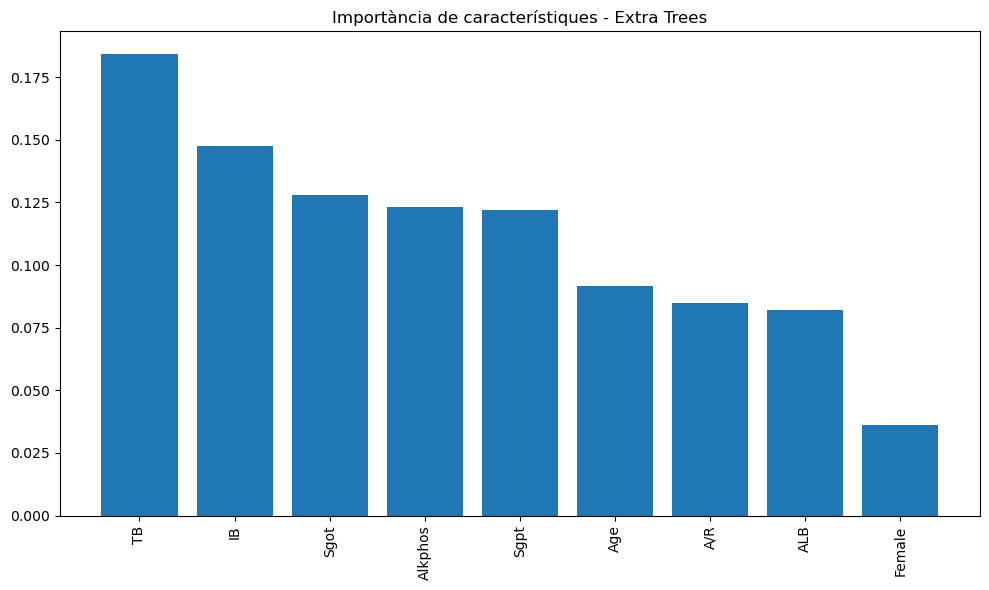

In [15]:
# Gràfic per veure característiques importants

feature_names = X_scaled_train_full_df.columns
importances_et = best_et_model_pipeline.named_steps['classifier'].feature_importances_
sorted_indices_et = np.argsort(importances_et)[::-1]

plt.figure(figsize=(10, 6)); plt.title("Importància de característiques - Extra Trees")
plt.bar(range(X_scaled_train_full_df.shape[1]), importances_et[sorted_indices_et], align='center')
plt.xticks(range(X_scaled_train_full_df.shape[1]), feature_names[sorted_indices_et], rotation=90)
plt.tight_layout(); plt.show()

Similar a la regressió logística, identifica TB, IB, Sgot i Alkphos com les característiques més importants per distingir entre pacients sans i malalts. 

Tot i això, l'Extra Trees se centra en la capacitat de cada característica per millorar la puresa dels nodes sense especificar directament si valors alts o baixos apunten a una classe o l'altra. Es destaca que 'TB' aparegui amb una importància més alta en Extra Trees, i també que la característica 'Female' es manté com una de les menys influents.

### **Model 3: Random Forest Classifier**

In [16]:
# Pipeline amb SMOTE i el model
pipeline_rf = ImbPipeline([('smote', smote_sampler), ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))])

# Trobar hiperparàmetres
grid_search_rf = GridSearchCV(pipeline_rf, {'classifier__n_estimators': [25, 75, 100, 150], 'classifier__max_depth': [10, 20], 'classifier__min_samples_split': [3, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4]}, cv=cv_strategy, scoring='f1_macro', refit=True)
grid_search_rf.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_rf_model_pipeline = grid_search_rf.best_estimator_
best_estimators_map['RandomForestClassifier'] = best_rf_model_pipeline
print(f"Millors hiperparàmetres RF mitjançant CV: {grid_search_rf.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_rf_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.30, 0.70, 81),
    model_name='RandomForestClassifier', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres RF mitjançant CV: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 75}
Millor llindar RandomForestClassifier (en les prediccions de cross-validation): 0.4950 amb F1 Macro: 0.6907


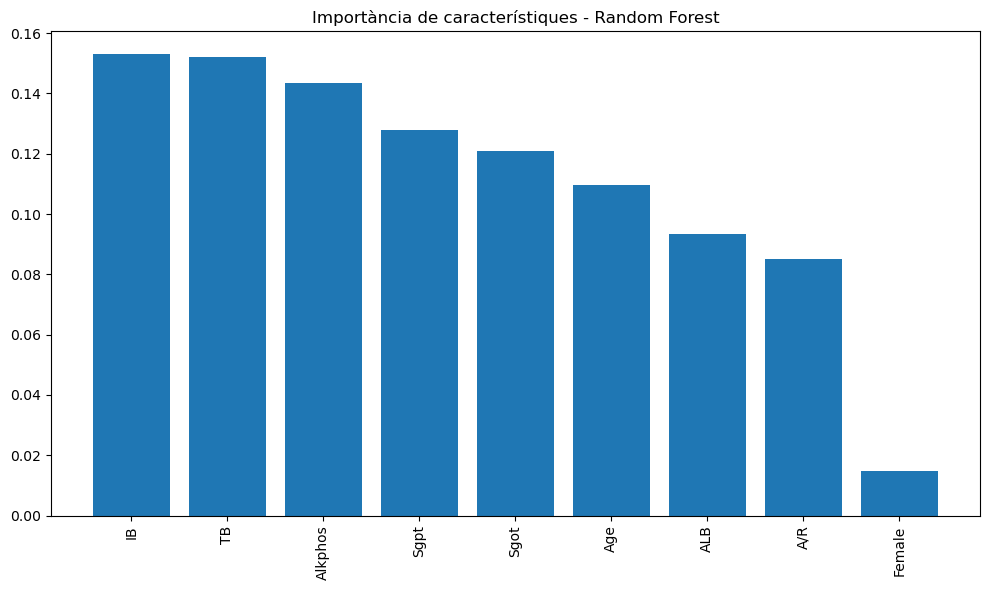

In [17]:
# Gràfic per veure característiques importants

importances_rf = best_rf_model_pipeline.named_steps['classifier'].feature_importances_
sorted_indices_rf = np.argsort(importances_rf)[::-1]
plt.figure(figsize=(10, 6)); plt.title("Importància de característiques - Random Forest")
plt.bar(range(X_scaled_train_full_df.shape[1]), importances_rf[sorted_indices_rf], align='center')
plt.xticks(range(X_scaled_train_full_df.shape[1]), feature_names[sorted_indices_rf], rotation=90)
plt.tight_layout(); plt.show()

Dona una importància molt similar a l'Extra Trees, amb IB, TB, Alkphos, Sgpt i Sgot com els principals factors per a la classificació. Com en els altres models, el gènere apareix com la característica menys influent.

### **Model 4: Support Vector Classifier**

In [18]:
# Pipeline amb SMOTE i el model
pipeline_svc = ImbPipeline([('smote', smote_sampler), ('classifier', SVC(random_state=RANDOM_STATE, probability=True))])

# Trobar hiperparàmetres
grid_search_svc = GridSearchCV(pipeline_svc, {'classifier__C': [0.01, 0.1, 1, 5, 10], 'classifier__kernel': ['rbf', 'linear'], 'classifier__gamma': ['auto', 0.01, 0.1]}, cv=cv_strategy, scoring='f1_macro', refit=True)
grid_search_svc.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_svc_model_pipeline = grid_search_svc.best_estimator_
best_estimators_map['SVC'] = best_svc_model_pipeline
print(f"Millors hiperparàmetres SVC mitjançant CV: {grid_search_svc.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_svc_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.30, 0.70, 81),
    model_name='SVC', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres SVC mitjançant CV: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Millor llindar SVC (en les prediccions de cross-validation): 0.5850 amb F1 Macro: 0.6474


### **Model 5: K-Nearest Neighbours**

In [19]:
# Pipeline amb SMOTE i el model
pipeline_knn = ImbPipeline([('smote', smote_sampler), ('classifier', KNeighborsClassifier())])

# Trobar hiperparàmetres
param_grid_knn = {'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 21], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=cv_strategy, scoring='f1_macro', refit=True)
grid_search_knn.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_knn_model_pipeline = grid_search_knn.best_estimator_
best_estimators_map['KNeighborsClassifier'] = best_knn_model_pipeline
print(f"Millors hiperparàmetres KNN mitjançant CV: {grid_search_knn.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_knn_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.20, 0.80, 121),
    model_name='KNeighborsClassifier', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres KNN mitjançant CV: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Millor llindar KNeighborsClassifier (en les prediccions de cross-validation): 0.5550 amb F1 Macro: 0.6562


### **Model 6: VotingClassifier**

SVM ha sigut descartat del VotingClassifier pel seu rendiment menor en cross-validation, i també ja que la seva inclusió en l'ensemble no va aportar cap millora en el test públic. Alguns dels pesos del GridSearch han sigut afegits tenint en compte el rendiment dels altres models en validació: per exemple, donant-li més importància a ET i RF per ser el millors.

In [20]:
# Models del nostre ensemble
estimators_voting = [('lr', best_estimators_map['LogisticRegression']), ('et', best_estimators_map['ExtraTreesClassifier']), ('rf', best_estimators_map['RandomForestClassifier']), ('knn', best_estimators_map['KNeighborsClassifier'])]

# Utilitzem pesos per a cada model
voting_pipeline_direct = VotingClassifier(estimators=estimators_voting, voting='soft')
grid_search_voting = GridSearchCV(voting_pipeline_direct, {'weights': [(1,1,1,1), (1,1,1,2), (1,1,2,1), (1,2,1,1), (2,1,1,1), (1,3,2,1), (1,6,5,1)]}, cv=cv_strategy, scoring='f1_macro', refit=True)
grid_search_voting.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_voting_model = grid_search_voting.best_estimator_
best_estimators_map['VotingClassifier'] = best_voting_model
print(f"Millors hiperparàmetres Voting mitjançant CV: {grid_search_voting.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_voting_model, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.3, 0.7, 121),
    model_name='VotingClassifier', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres Voting mitjançant CV: {'weights': (1, 6, 5, 1)}
Millor llindar VotingClassifier (en les prediccions de cross-validation): 0.4733 amb F1 Macro: 0.6926


**Experiment 5**

- **Hipòtesi:** El `hard-voting`, que pren decisions per majoria simple, podria ser més robust i generalitzar millor que el `soft-voting`, que es basa en les probabilitats predites i pot ser sensible a models mal calibrats.

- **Acció:** Es va crear un `VotingClassifier` addicional amb l'estratègia `voting='hard'`. Aquest model es va avaluar directament amb `cross_val_score` i la mètrica `f1_macro`, ja que no permet l'optimització de llindars de probabilitat.

- **Resultat:** El rendiment del `hard-voting` va ser molt bon, obtenint un F1-score en validació creuada de **0.6924**. Aquest resultat és pràcticament idèntic al del `soft-voting` (F1-score de **0.6926**), demostrant que les dues estratègies són molt efectives per a aquest conjunt de dades.

- **Conclusió:** Tot i que la diferència de rendiment entre ambdues estratègies és mínima, es va seleccionar `soft-voting` com a mètode principal. Aquesta decisió es basa en la seva major flexibilitat, ja que permet ponderar la importància de cada classificador base mitjançant l'ajust de pesos. A més, a diferència del hard-voting, genera prediccions de probabilitat, la qual cosa permet optimitzar el llindar de decisió i assegura una comparació millor amb els altres models avaluats.

In [21]:
# Prova amb hard-voting

hard_voting_pipeline = ImbPipeline([
    ('smote', smote_sampler), ('classifier', VotingClassifier(estimators=estimators_voting, voting='hard'))
])

hard_voting_f1_scores = cross_val_score(
    hard_voting_pipeline, X_scaled_train_full_df, y_labels, cv=cv_strategy, scoring='f1_macro'
)

mean_f1_hard = np.mean(hard_voting_f1_scores)
print(f"F1 Macro (en CV) per al VotingClassifier (hard): {mean_f1_hard:.4f}")

df_scores_final_with_hard = pd.DataFrame.from_dict(all_model_f1_optimized, orient='index', columns=['F1 Validació'])
df_scores_final_with_hard = df_scores_final_with_hard.sort_values(by="F1 Validació", ascending=False)

F1 Macro (en CV) per al VotingClassifier (hard): 0.6924


**Experiment 6**

- **Hipòtesi:** L'ús d'un `hard-voting` només amb els dos millors models en validació (`ExtraTrees` i `RandomForest`) podria simplificar el classificador final i mantenir o fins i tot millorar el rendiment, en eliminar la influència de models menys potents.

- **Acció:** Es va crear un `VotingClassifier` addicional amb `voting='hard'` que només incloïa els dos millors estimadors (`ExtraTrees` i `RandomForest`). Es va avaluar el seu rendiment amb `cross_val_score` utilitzant la mètrica `f1_macro`.

- **Resultat:** Contràriament a la hipòtesi, el rendiment va disminuir. L'F1-score obtingut en validació creuada va ser de **0.6778**, un resultat notablement inferior al dels ensembles que utilitzaven quatre models (prop de 0.692).

- **Conclusió:** Aquesta reducció en el rendiment suggereix que, tot i ser individualment menys potents, els classificadors com la Regressió Logística i KNN aporten una diversitat important al procés de votació que millora la generalització del model final. Per tant, es va descartar aquest ensemble simplificat a favor dels models que incorporen més diversitat.

In [22]:
# Experiment 6: VotingClassifier (hard) amb només ET i RF

estimators_hard_best = [
    ('et', best_estimators_map['ExtraTreesClassifier']),
    ('rf', best_estimators_map['RandomForestClassifier'])
]

hard_voting_best_pipeline = ImbPipeline([
    ('smote', smote_sampler), ('classifier', VotingClassifier(estimators=estimators_hard_best, voting='hard'))
])

hard_voting_best_f1_scores = cross_val_score(
    hard_voting_best_pipeline, X_scaled_train_full_df, y_labels, cv=cv_strategy, scoring='f1_macro'
)

mean_f1_hard_best = np.mean(hard_voting_best_f1_scores)

print(f"F1 Macro (en CV) per al VotingClassifier (només ET i RF): {mean_f1_hard_best:.4f}\n")

F1 Macro (en CV) per al VotingClassifier (només ET i RF): 0.6778



### **Model 7: Stacking Classifier**

In [23]:
estimators_stacking = [
    ('lr', best_estimators_map['LogisticRegression']),
    ('et', best_estimators_map['ExtraTreesClassifier']),
    ('rf', best_estimators_map['RandomForestClassifier']),
    ('svc', best_estimators_map['SVC'])
]

stacking_clf = StackingClassifier(estimators=estimators_stacking, final_estimator=LogisticRegression(random_state=RANDOM_STATE), cv=cv_strategy)

# Pipeline amb SMOTE i el nostre StackingClassifier (només s'aplica a les dades d'entrenament dels estimadors base)
pipeline_stack = ImbPipeline([('smote', smote_sampler), ('classifier', stacking_clf)])

# Ajustar hiperparàmetres meta-model
param_grid_stack = {'classifier__final_estimator__C': [0.1, 1.0, 10.0]}
grid_search_stack = GridSearchCV(pipeline_stack, param_grid=param_grid_stack, cv=cv_strategy, scoring='f1_macro', refit=True)
grid_search_stack.fit(X_scaled_train_full_df, y_labels)

# Guardem millor model amb els seus hiperparàmetres
best_stack_model_pipeline = grid_search_stack.best_estimator_
best_estimators_map['StackingClassifier'] = best_stack_model_pipeline
print(f"Millors hiperparàmetres Stacking mitjançant CV: {grid_search_stack.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_stack_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.30, 0.70, 81),
    model_name='StackingClassifier', thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

Millors hiperparàmetres Stacking mitjançant CV: {'classifier__final_estimator__C': 1.0}
Millor llindar StackingClassifier (en les prediccions de cross-validation): 0.4850 amb F1 Macro: 0.6927


**Experiment 7**

- **Hipòtesi:** Un meta-classificador més complex i no lineal com `RandomForest` podria capturar millor les interaccions entre les prediccions dels models base, superant el rendiment d'un lineal com `LogisticRegression`.

- **Acció:** Es va substituir el final_estimator de `LogisticRegression` per un `RandomForest` dins del StackingClassifier i es van optimitzar els seus hiperparàmetres mitjançant GridSearchCV.

- **Resultat:** El rendiment va ser pràcticament idèntic. El Stacking amb Regressió Logística va obtenir un F1-score de **0.6927**, mentre que el model amb Random Forest va assolir un F1-score de **0.6923**.

- **Conclusió:** Tot i que `RandomForest` és un model molt més complex, no va aportar una millora rellevant en el rendiment. Donat que la `LogisticRegression` és computacionalment molt més eficient i ofereix un resultat gairebé igual, s'ha mantingut per la seva simplicitat i equilibri entre rendiment i cost computacional.

In [24]:
# Experiment 7: StackingClassifier amb RandomForest com a meta-model

# S'aprofita el que ja es va declarar abans per no repetir
stacking_clf = StackingClassifier(estimators=estimators_stacking, final_estimator=RandomForestClassifier(random_state=RANDOM_STATE), cv=cv_strategy)

pipeline_stack = ImbPipeline([('smote', smote_sampler), ('classifier', stacking_clf)])

param_grid_stack = {
    'classifier__final_estimator__n_estimators': [50, 100], 'classifier__final_estimator__max_depth': [5, 10]
}

grid_search_stack = GridSearchCV(pipeline_stack, param_grid=param_grid_stack, cv=cv_strategy, scoring='f1_macro', refit=True)

grid_search_stack.fit(X_scaled_train_full_df, y_labels)

best_stack_model_pipeline = grid_search_stack.best_estimator_

model_name_stack_rf = 'StackingClassifier_RF'
print(f"Millors hiperparàmetres Stacking (RF) mitjançant CV: {grid_search_stack.best_params_}")

# Llindar òptim sobre un subset de validació
find_optimal_threshold(
    model_pipeline=best_stack_model_pipeline, X=X_scaled_train_full_df, y=y_labels, cv_strategy=cv_strategy, threshold_range=np.linspace(0.30, 0.70, 81),model_name=model_name_stack_rf,
    thresholds_map=best_thresholds_map_cv, f1_scores_map=all_model_f1_optimized
)

del all_model_f1_optimized[model_name_stack_rf] # no ha millorat i no el posem a la taula final

Millors hiperparàmetres Stacking (RF) mitjançant CV: {'classifier__final_estimator__max_depth': 10, 'classifier__final_estimator__n_estimators': 50}
Millor llindar StackingClassifier_RF (en les prediccions de cross-validation): 0.4100 amb F1 Macro: 0.6923


### **Comparació de models**

In [25]:
# Funció auxiliar per les mètriques de cada model

def evaluate_model_performance(y_true, y_pred, y_pred_proba, model_name="Model", show_plot=True):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    accuracy = accuracy_score(y_true, y_pred)
    
    # Precisió i recall per a les dues classes
    precision_0 = precision_score(y_true, y_pred, pos_label=0)
    recall_0 = recall_score(y_true, y_pred, pos_label=0)
    precision_1 = precision_score(y_true, y_pred, pos_label=1)
    recall_1 = recall_score(y_true, y_pred, pos_label=1)

    print(f"> Model: {model_name}\n")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"AUC-ROC (per Sa):   {roc_auc:.4f}")
    print(f"Exactitud (orientativa, tenim desequilibri): {accuracy:.4f}\n")
    
    print(f"Classe 0 (Malalt):")
    print(f"  Precisió: {precision_0:.4f}")
    print(f"  Recall:   {recall_0:.4f}")
    
    print(f"\nClasse 1 (Sa):")
    print(f"  Precisió: {precision_1:.4f}")
    print(f"  Recall:   {recall_1:.4f}")


    if show_plot:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred. Malalt (0)', 'Pred. Sa (1)'],
                    yticklabels=['Real Malalt (0)', 'Real Sa (1)'])
        plt.xlabel("Etiqueta predita"); plt.ylabel("Etiqueta real")
        plt.title(f"Matriu de confusió - {model_name}\n(F1 Macro: {f1_macro:.4f})")
        plt.show()
        
    metrics = {"F1 Macro": f1_macro, "AUC-ROC (Sa)": roc_auc, "Exactitud": accuracy,
               "Precisió (Malalt=0)": precision_0, "Recall (Malalt=0)": recall_0,
               "Precisió (Sa=1)": precision_1, "Recall (Sa=1)": recall_1}
    return metrics


--- MÈTRIQUES DE TOTS ELS MODELS ---

Llindar escollit per a LogisticRegression: 0.5100
> Model: LogisticRegression

F1-score (macro): 0.6628
AUC-ROC (per Sa):   0.7394
Exactitud (orientativa, tenim desequilibri): 0.6825

Classe 0 (Malalt):
  Precisió: 0.8770
  Recall:   0.6465

Classe 1 (Sa):
  Precisió: 0.4658
  Recall:   0.7727


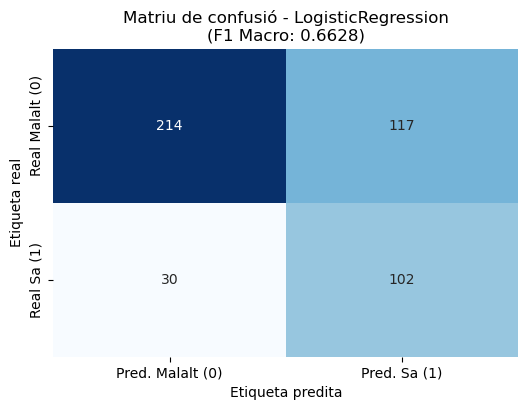

Llindar escollit per a ExtraTreesClassifier: 0.4850
> Model: ExtraTreesClassifier

F1-score (macro): 0.7062
AUC-ROC (per Sa):   0.7756
Exactitud (orientativa, tenim desequilibri): 0.7387

Classe 0 (Malalt):
  Precisió: 0.8671
  Recall:   0.7492

Classe 1 (Sa):
  Precisió: 0.5311
  Recall:   0.7121


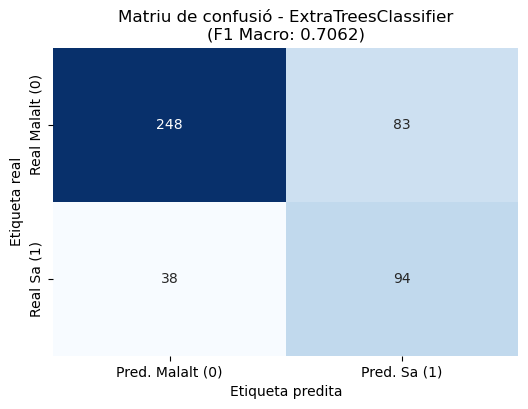

Llindar escollit per a RandomForestClassifier: 0.4950
> Model: RandomForestClassifier

F1-score (macro): 0.6907
AUC-ROC (per Sa):   0.7599
Exactitud (orientativa, tenim desequilibri): 0.7473

Classe 0 (Malalt):
  Precisió: 0.8242
  Recall:   0.8218

Classe 1 (Sa):
  Precisió: 0.5564
  Recall:   0.5606


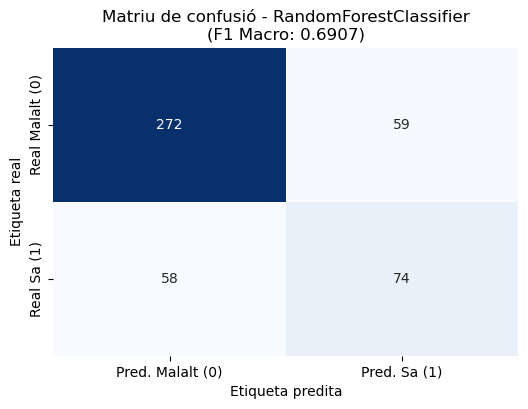

Llindar escollit per a SVC: 0.5850
> Model: SVC

F1-score (macro): 0.6474
AUC-ROC (per Sa):   0.7014
Exactitud (orientativa, tenim desequilibri): 0.6933

Classe 0 (Malalt):
  Precisió: 0.8161
  Recall:   0.7372

Classe 1 (Sa):
  Precisió: 0.4695
  Recall:   0.5833


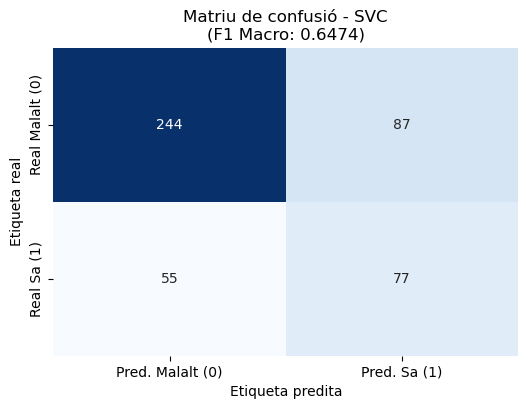

Llindar escollit per a KNeighborsClassifier: 0.5550
> Model: KNeighborsClassifier

F1-score (macro): 0.6562
AUC-ROC (per Sa):   0.7362
Exactitud (orientativa, tenim desequilibri): 0.6890

Classe 0 (Malalt):
  Precisió: 0.8400
  Recall:   0.6979

Classe 1 (Sa):
  Precisió: 0.4681
  Recall:   0.6667


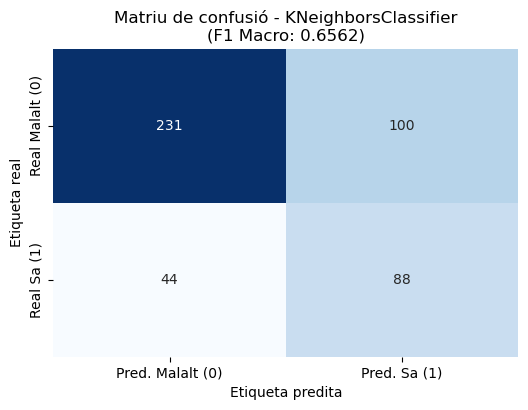

Llindar escollit per a VotingClassifier: 0.4733
> Model: VotingClassifier

F1-score (macro): 0.6926
AUC-ROC (per Sa):   0.7769
Exactitud (orientativa, tenim desequilibri): 0.7257

Classe 0 (Malalt):
  Precisió: 0.8592
  Recall:   0.7372

Classe 1 (Sa):
  Precisió: 0.5140
  Recall:   0.6970


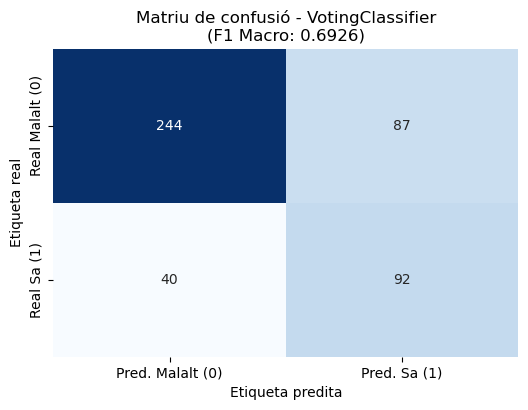

Llindar escollit per a StackingClassifier: 0.4850
> Model: StackingClassifier

F1-score (macro): 0.6927
AUC-ROC (per Sa):   0.7689
Exactitud (orientativa, tenim desequilibri): 0.7559

Classe 0 (Malalt):
  Precisió: 0.8187
  Recall:   0.8459

Classe 1 (Sa):
  Precisió: 0.5785
  Recall:   0.5303


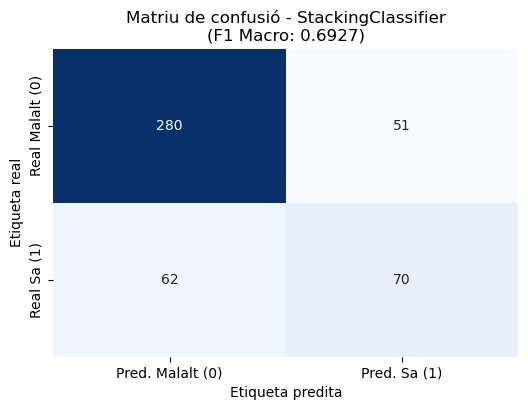

In [26]:
print("\n--- MÈTRIQUES DE TOTS ELS MODELS ---\n")

for model_name, model_pipeline in best_estimators_map.items():
    
    y_proba_cv = cross_val_predict(model_pipeline, X_scaled_train_full_df, y_labels, cv=cv_strategy, method='predict_proba')
    
    optimal_threshold = best_thresholds_map_cv.get(model_name, 0.5)
    
    y_pred_cv = (y_proba_cv[:, 1] >= optimal_threshold).astype(int)
    
    print(f"Llindar escollit per a {model_name}: {optimal_threshold:.4f}")
    evaluate_model_performance(
        y_true=y_labels, 
        y_pred=y_pred_cv, 
        y_pred_proba=y_proba_cv, 
        model_name = model_name,
        show_plot=True
    )

In [27]:
df_scores_final = pd.DataFrame.from_dict(all_model_f1_optimized, orient='index', columns=['F1 Validació'])

df_scores_final = df_scores_final.sort_values(by="F1 Validació", ascending=False)

print(df_scores_final)

best_model_name_cv = df_scores_final.index[0]
final_model_for_submission = best_estimators_map[best_model_name_cv]
final_threshold_for_submission = best_thresholds_map_cv[best_model_name_cv]

print(f"\nModel final escogit: {best_model_name_cv}, amb F1 en validació: {df_scores_final.loc[best_model_name_cv, 'F1 Validació']:.4f}")


                        F1 Validació
ExtraTreesClassifier        0.706152
StackingClassifier          0.692727
VotingClassifier            0.692568
RandomForestClassifier      0.690743
LogisticRegression          0.662772
KNeighborsClassifier        0.656188
SVC                         0.647437

Model final escogit: ExtraTreesClassifier, amb F1 en validació: 0.7062


### **Comentaris a destacar dels models**

Donem unes observacions que es detallaran al document dels resultats:

*   **Rendiment superior dels models ensemble**: L'**`ExtraTreesClassifier`** (F1-macro: **0.7062**) destaca com el millor model, seguit de prop pels altres mètodes ensemble com l'**`StackingClassifier`** (0.6927) i el **`VotingClassifier`** (0.6926). Aquests models demostren una capacitat superior per trobar un equilibri sòlid entre la detecció de pacients sans i malalts, beneficiant-se de la combinació de diversos classificadors base.

*   **Compromís entre precisió i recall**: S'observa un clar trade-off entre mètriques. Models com la **`LogisticRegression`** obtenen un recall alt per a la classe sana (0.77), però a costa d'un recall baix per a la classe malalta (0.65), la qual cosa representa un risc mèdic elevat (falsos negatius). Per contra, **`RandomForest`** és més eficaç detectant pacients malalts (recall de 0.82) però menys precís amb els sans (recall de 0.56). Per gestionar aquest compromís, s'ha buscat un **llindar de probabilitat òptim** per a cada model, maximitzant l'F1-score (macro) per garantir un bon equilibri.

*   **Rendiment en la classe minoritària (sans)**: Cal destacar que la precisió i el recall per a la classe sana (1) són generalment més baixos. Això es deu principalment al fort **desequilibri de classes** inicial; tot i l'ús de SMOTE, el model disposa de menys informació real sobre els pacients sans. L'optimització del llindar de decisió, centrada en l'F1-macro, busca un equilibri global.

*   **Elecció final: `ExtraTreesClassifier`**: Encara que els models *ensemble* com `Voting` i `Stacking` són molt competitius, l'**`ExtraTreesClassifier`** es selecciona com a model final. No només presenta el **millor F1-score (macro)** en validació, sinó que també ofereix un excel·lent equilibri en el recall per a ambdues classes (0.75 per a malalts i 0.71 per a sans). Aquest balanç el converteix en el model més fiable i robust per a aquest problema, evitant els comportaments extrems d'altres classificadors. El seu bon rendiment en validació es complementa amb un resultat sòlid en el test públic del 66.66%.

### **Prediccions i submissió**

In [28]:
# Obtenim probabilitats i apliquem el llindar
proba_test_submission = final_model_for_submission.predict_proba(X_scaled_test_kaggle_df)
preds_test_submission = (proba_test_submission[:, 1] >= final_threshold_for_submission).astype(int)

submission_df = pd.DataFrame({
    'ID': np.arange(1, len(preds_test_submission) + 1),
    'Prediction': preds_test_submission
})

submission_filename = 'submission_final.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nS'ha generat l'arxiu {submission_filename}.\n")
print("Primeres files:")
print(submission_df.head())


S'ha generat l'arxiu submission_final.csv.

Primeres files:
   ID  Prediction
0   1           1
1   2           0
2   3           1
3   4           0
4   5           1
